In [29]:
####################################
#                                  #
#  call_log_analyzer.ipynb         #
#  Akhil Garg, akhil@akhilgarg.ca  #
#  Created 2021-04-16              #
#                                  #
####################################

'''
Takes in a gmail call log as a .mbox file
And returns a pandas dataframe of calls made
to the Kingston Health Sciences Centre
'''

import pandas  as pd
import numpy   as np
import mailbox as mb
import matplotlib.pyplot as plt

## Date and types of on-calls

In [30]:
# List of calls, their start times, and type
# The time "resets" at 10 am for each call
oncall_data = [('2021-04-15','Subspec'),
               ('2021-04-27','Subspec'),
               ('2021-04-29','Subspec'),
               ('2021-05-01','Subspec'),
               ('2021-05-05','Hero'),
               ('2021-05-10','Hero'),
               ('2021-05-13','Non-take'),
               ('2021-06-20','CTU-J')]

# Empty dataframe of start and end dates
oncalls = pd.DataFrame(columns = ['Start','End','Type'])

for oncall in oncall_data:
    start = pd.to_datetime(oncall[0] + ' 10:00').tz_localize(None)
    # For each call shift start, the end is the next day at 10 AM
    end = str((start + pd.DateOffset(1)).date()) + ' 10:00'
    end = pd.to_datetime(end)

    oncalls = oncalls.append({'Start':start,
                              'End':end,
                              'Type':oncall[1]
                             },ignore_index=True)

# Create an index
oncalls = oncalls.set_index(oncalls['Start'].dt.date)
oncalls = oncalls.rename_axis('On-call Day')

# Store all call types for later
call_types = sorted(set(oncalls['Type'].values))

oncalls

,Start,End,Type
On-call Day,,,
2021-04-15,2021-04-15 10:00:00,2021-04-16 10:00:00,Subspec
2021-04-27,2021-04-27 10:00:00,2021-04-28 10:00:00,Subspec
2021-04-29,2021-04-29 10:00:00,2021-04-30 10:00:00,Subspec
2021-05-01,2021-05-01 10:00:00,2021-05-02 10:00:00,Subspec
2021-05-05,2021-05-05 10:00:00,2021-05-06 10:00:00,Hero
2021-05-10,2021-05-10 10:00:00,2021-05-11 10:00:00,Hero
2021-05-13,2021-05-13 10:00:00,2021-05-14 10:00:00,Non-take
2021-06-20,2021-06-20 10:00:00,2021-06-21 10:00:00,CTU-J


## Parse call log data from gmail

In [31]:
mail_list = mb.mbox('Call log.mbox')
call_log  = pd.DataFrame(columns = ['Timestamp','Duration'])

for message in mail_list:
    
    # Skip non call log emails
    if 'Call log' not in message['X-Gmail-Labels'].split(','): continue
    
    # Only keep calls associated with the Kingston Health Sciences Centre
    if ('Kingston Health Sciences Centre' not in message['Subject']) and \
       (message['X-smssync-address'] != '16135496666'): continue
    
    # Calculate timestamp and duration of call
    timestamp = pd.to_datetime(message['Date']).tz_localize(None)
    
    duration  = message.get_payload().split('\n')[0] #1st line is duration
    duration  = duration.split('s')[0] #part before 's' is duration in seconds
    duration  = int(duration)
    
    call_log = call_log.append({'Timestamp':timestamp,'Duration':duration},ignore_index=True)

call_log

,Timestamp,Duration
0,2021-04-29 21:39:46,130
1,2021-04-29 21:36:06,178
2,2021-04-29 21:23:50,97
3,2021-04-29 20:32:20,84
4,2021-04-29 20:08:56,37
...,...,...
295,2020-07-08 20:54:45,86
296,2020-07-08 20:47:19,84
297,2020-07-08 17:16:51,61
298,2020-07-08 17:04:04,168


### Hard-code any missing calls here

In [32]:
# Add more phone calls in the format (Timestamp, Duration)
missing_phones = [('2021-06-20 14:30','60'),
                  ('2021-06-20 17:00','60')]

for phone_call in missing_phones:
    timestamp = pd.to_datetime(phone_call[0])
    duration  = int(phone_call[1])

    call_log = call_log.append({'Timestamp':timestamp,'Duration':duration},ignore_index=True)

# Sort, clean, and re-index
call_log = call_log.sort_values(by='Timestamp')  
call_log = call_log.drop_duplicates()
call_log = call_log.reset_index(drop=True)

call_log['Duration']

0        0
1      168
2       61
3       84
4       86
      ... 
297    161
298     33
299     98
300     60
301     60
Name: Duration, Length: 302, dtype: object

## Relate phone call data to specific on-calls

In [33]:
# Dataframe of all pages on all calls
all_calls = pd.DataFrame(columns=['Timestamp','Duration','Type'])
pd.options.mode.chained_assignment = None #suppress warning

for oncall in oncalls.itertuples():
    
    # Itertuples generates tuples of (index,start,end,type)
    new_calls = call_log[(call_log['Timestamp'] > oncall[1]) &
                         (call_log['Timestamp'] < oncall[2])]
    new_calls['Type'] = oncall[3]

    print('Stats from {} call on {}:\n'.format(oncall[3],oncall[0]))            
    print('Total pages             {}'.format(len(new_calls.index)))
    
    try:
        min(new_calls['Timestamp'])
        print('Mean duration of each   {:.1f}s'.format(new_calls['Duration'] .mean()))
        print('Earliest page           {}'.format(min(new_calls['Timestamp']).time()))
        print('Latest page             {}'.format(max(new_calls['Timestamp']).time()))
    
    # If there are no calls that particular day
    except ValueError: continue
    
    print('\n')

    all_calls = all_calls.append(new_calls)
    
all_calls = all_calls.reset_index(drop=True)

print('Total number of calls: {}'.format(len(all_calls.index)))

Stats from Subspec call on 2021-04-15:

Total pages             33
Mean duration of each   80.3s
Earliest page           17:20:16
Latest page             07:54:21


Stats from Subspec call on 2021-04-27:

Total pages             19
Mean duration of each   91.6s
Earliest page           16:45:52
Latest page             02:10:50


Stats from Subspec call on 2021-04-29:

Total pages             32
Mean duration of each   108.7s
Earliest page           16:27:45
Latest page             06:37:34


Stats from Subspec call on 2021-05-01:

Total pages             17
Mean duration of each   81.6s
Earliest page           12:48:59
Latest page             05:57:06


Stats from Hero call on 2021-05-05:

Total pages             1
Mean duration of each   116.0s
Earliest page           17:04:30
Latest page             17:04:30


Stats from Hero call on 2021-05-10:

Total pages             2
Mean duration of each   66.5s
Earliest page           15:27:46
Latest page             22:35:43


Stats from Non-t

### Count the number of calls during each hour

In [34]:
# Create a dataframe grouped by hour and call type
hourly_group = all_calls.groupby(
    [pd.Grouper(key='Timestamp',freq='H'),all_calls.Type]) \
    .size() \
    .reset_index(name='Count') \
    .set_index('Timestamp') \
    .asfreq(freq='H') # interpolate missing hours with NaN


# Add 24 hours of data before and after each call, 
# to ensure that all hours are accounted for
# they should at minimum have 'zero' data
for call in call_types:

    reverse_hours = pd.DataFrame(index=pd.date_range(
         start=hourly_group[hourly_group['Type']==call].index.min()-pd.Timedelta('24h'),
         periods=24,
         freq='H'),
         data={'Type':call},
         columns=['Type','Count'])
    
    forward_hours = pd.DataFrame(index=pd.date_range(
         start=hourly_group[hourly_group['Type']==call].index.max(),
         periods=24,
         freq='H'),
         data={'Type':call},
         columns=['Type','Count'])
      
    hourly_group = hourly_group.append([reverse_hours,forward_hours])
        
# Add a column for hour only, ignoring dates
hourly_group['Hour'] = hourly_group.index.map(lambda x: x.hour)

# Rearrange columns
hourly_group = hourly_group[['Hour','Type','Count']]

# Add missing values
all_hours = pd.DataFrame()
for day in oncalls.itertuples():
    
    # Only keep times that are on call
    # Shifting start time forward by 1 second makes it an open interval
    hg = hourly_group[pd.Series(hourly_group.index).between(day.Start+pd.Timedelta('1s'),
                                                            day.End).values]
    
    # Fill in call type name
    hg['Type'] = hg['Type'].fillna(value=hg['Type'].mode()[0])
    
    # For hours with no calls, fill with zero
    hg['Count'] = hg['Count'].fillna(0)
        
    # Add these to a new dataframe
    all_hours = all_hours.append(hg)

# Remove duplicate indices    
all_hours = all_hours[~all_hours.index.duplicated(keep='first')]

# Sort by date (which is the index)
all_hours = all_hours.sort_index()
all_hours

,Hour,Type,Count
2021-04-15 11:00:00,11,Subspec,0.0
2021-04-15 12:00:00,12,Subspec,0.0
2021-04-15 13:00:00,13,Subspec,0.0
2021-04-15 14:00:00,14,Subspec,0.0
2021-04-15 15:00:00,15,Subspec,0.0
...,...,...,...
2021-06-21 06:00:00,6,CTU-J,0.0
2021-06-21 07:00:00,7,CTU-J,0.0
2021-06-21 08:00:00,8,CTU-J,0.0
2021-06-21 09:00:00,9,CTU-J,0.0


## Make a heatmap of number of pages per hour

### Averaged over each call type

In [35]:
# Take the mean of number of calls per hour per type of call
# hourly_means = all_hours.groupby(['Type','Hour'])['Count'].mean()
hourly_means = all_hours.groupby(['Type','Hour'])['Count'].mean()

# Shift the range to start at 11 am instead of at midnight
hour_list = list(range(11,24))+list(range(11))
hourly_means = hourly_means.reindex(hour_list,level=1)

# Convert data to an array to be plotted
heatmap_data = []
for call_type in call_types:
    heatmap_data.append(hourly_means[call_type].values)

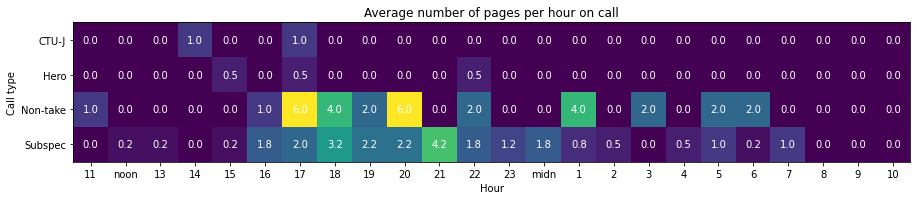

In [36]:
# Make the figure
fig, ax = plt.subplots(figsize=(15,5))
        
ax.imshow(heatmap_data)

# Format tickmarks
ax.set_xticks(np.arange(len(hour_list)))
ax.set_yticks(np.arange(len(call_types)))
# Convert 12 to noon and 0 to midnight, 
# and convert int to str to prevent re-ordering
x_ticks = [str({12:'noon',0:'midn'}.get(x,x)) for x in hour_list]
ax.set_xticklabels(x_ticks)
ax.set_yticklabels(call_types)

# Add labels
for i in range(len(call_types)):
    for j in range(len(hour_list)):
        text = ax.text(j, i, '{:.1f}'.format(heatmap_data[i][j]),
                       ha="center", va="center", color="w")

# Label the axes
ax.set_xlabel('Hour')
ax.set_ylabel('Call type')
ax.set_title ('Average number of pages per hour on call')

plt.show()

### For each individual call

In [42]:
# Create a string for each call to display on the heatmap

def hour_11(date):
    '''
    Given a pandas datetime object
    Returns the current day 
        if the time is between [11 am, midnight)
    Or the previous day 
        if the time is between [midnight and 11 am)
    '''
    
    if 11 <= date.hour <= 23:
        return date.strftime(' %b %d')
        
    elif 0 <= date.hour < 11:
        return (date - pd.Timedelta('1D')).strftime(' %b %d')
        
    else: raise Exception('Something went wrong with the time')

all_call_names = []
for hour in all_hours.itertuples():
    all_call_names.append(hour.Type+hour_11(hour.Index))

# Sort by date
all_call_names = list(dict.fromkeys(all_call_names))

# Convert data to an array to be plotted
heatmap_data = np.array(all_hours['Count'].values).reshape(len(all_call_names),24)

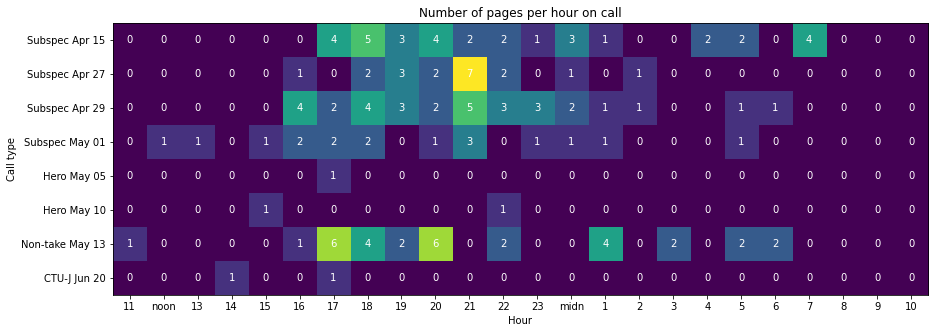

In [43]:
# Make the figure
fig, ax = plt.subplots(figsize=(15,5))
        
ax.imshow(heatmap_data)

# Format tickmarks
ax.set_xticks(np.arange(len(hour_list)))
ax.set_yticks(np.arange(len(all_call_names)))
# Convert 12 to noon and 0 to midnight, 
# and convert int to str to prevent re-ordering
x_ticks = [str({12:'noon',0:'midn'}.get(x,x)) for x in hour_list]
ax.set_xticklabels(x_ticks)
ax.set_yticklabels(all_call_names)

# Add labels
for i in range(len(all_call_names)):
    for j in range(len(hour_list)):
        text = ax.text(j, i, '{:.0f}'.format(heatmap_data[i][j]),
                       ha="center", va="center", color="w")

# Label the axes
ax.set_xlabel('Hour')
ax.set_ylabel('Call type')
ax.set_title ('Number of pages per hour on call')

plt.show()